In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(2147483647)

In [3]:
# read dataset
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [4]:
# extract vocabulary -> chars in dataset
# words (names) -> join -> set -> list -> sort
chars = sorted(list(set(''.join(words))))
# create dict: str -> int
stoi = {'.': 0}
stoi.update({s: i+1 for i, s in enumerate(chars)})
print('stoi: ', stoi)
SZ = len(stoi)
print(SZ)
# create dict: int -> str
itos = {i: s for s, i in stoi.items()}
print('itos: ', itos)

stoi:  {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
27
itos:  {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [6]:
# build the dataset
block_sz = 5  # context size
def build_dataset(words):
  X, y = [], []
  for w in words:
    # print(w)
    context = [0] * block_sz
    for c in w + '.':
      ix = stoi[c]
      X.append(context)
      y.append(ix)
      # print(''.join(itos[i] for i in context), ' -----> ', itos[ix])
      context = context[1:] + [ix]  # slide the context by 1 char to right
  X = torch.tensor(X)
  y = torch.tensor(y)
  print(X.shape, X.dtype, y.shape, y.dtype)
  return X, y

# train (train model params), validation/dev (train hyperparams), test splits (use only a few times)
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.copy()  # create a copy to be repeatable
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))
Xtr, ytr = build_dataset(shuffled_words[:n1])
Xdev, ydev = build_dataset(shuffled_words[n1:n2])
Xte, yte = build_dataset(shuffled_words[n2:])

torch.Size([182625, 5]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 5]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 5]) torch.int64 torch.Size([22866]) torch.int64


In [7]:
# embeddings - embed 27 chars (vocabulary) in 2-dimensional space
C = torch.randn((SZ, 2))
print(C.shape)
C[:2]

torch.Size([27, 2])


tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008]])

In [8]:
# Example - how to embed an integer into 27x2 dimensional tensor?
num = 1
# method 1 - just index C
print(C[num])  # simpler, faster, preferred way
# method 2
oh = F.one_hot(torch.tensor(num), num_classes=SZ).float()
print(oh)
print(oh @ C)

# more examples
print(C[[0, 1, 2]])
print(C[torch.tensor([0, 1, 2])])

tensor([-0.0274, -1.1008])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([-0.0274, -1.1008])
tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296]])
tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296]])


In [9]:
# examples of pytorch indexing
print(C[Xtr].shape)
print(Xtr[13], Xtr[13,2])
print(C[Xtr][13,2])
print(C[1])

torch.Size([182625, 5, 2])
tensor([ 9, 15, 14,  4, 18]) tensor(14)
tensor([-1.2199,  0.3031])
tensor([-0.0274, -1.1008])


In [10]:
# embed the input
emb = C[Xtr]
print(C.shape)
print(Xtr.shape)
print(emb.shape)

torch.Size([27, 2])
torch.Size([182625, 5])
torch.Size([182625, 5, 2])


In [15]:
# hidden layer
num_neurons = 100
W1 = torch.randn((block_sz * 2, num_neurons))  # 6 = 3x2, block_sz=3, 2-dimensional embedding
b1 = torch.randn(num_neurons)

In [17]:
# the following will error out
# emb @ W1 + b1  # RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)
# need to transform 32x3x2 --> 32x6
# examples of transformations -->
a = torch.arange(6)
print(a)
print(a.shape)
print(a.view((2,3)))
print(a.view((3,2)))
h = torch.tanh(emb.view(-1, block_sz * 2) @ W1 + b1)
h.shape
# broadcasting
# emb @ W1: 32x100
# b1      :    100
#         :  1x100

tensor([0, 1, 2, 3, 4, 5])
torch.Size([6])
tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[0, 1],
        [2, 3],
        [4, 5]])


torch.Size([182625, 100])

In [18]:
# final layer
W2 = torch.randn((num_neurons, SZ))  # 100x27
b2 = torch.randn(SZ)
logits = h @ W2 + b2
print(logits.shape)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)
print(prob[0].sum())  # must be normalized i.e. sum must be 1
loss = -prob[torch.arange(prob.shape[0]), ytr].log().mean()
print(loss)

torch.Size([182625, 27])
torch.Size([182625, 27])
tensor(1.)
tensor(19.6908)


In [19]:
# cross_entropy
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(prob.shape[0]), ytr].log().mean()
print(loss)
# preferred way to calculate loss --> cross_entropy
#   forward pass more efficient
#   backward pass more efficient
#   things much more well behaved
loss = F.cross_entropy(logits, ytr)
print(loss)

tensor(19.6908)
tensor(19.6908)


In [20]:
# puts everything together
Xtr.shape, ytr.shape

(torch.Size([182625, 5]), torch.Size([182625]))

In [21]:
print(block_sz)
g = torch.Generator().manual_seed(2147483647)
emb_dim = 10  # embedding dimensions
C = torch.randn((SZ, emb_dim), generator=g)
num_neurons = 200
W1 = torch.randn((block_sz * emb_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, SZ), generator=g)
b2 = torch.randn(SZ, generator=g)
params = [C, W1, b1, W2, b2]
nparams = sum(p.nelement() for p in params)
print(nparams)

5
15897


In [22]:
for p in params:
  # tells PyTorch to calculate gradients of loss w.r.t. these params during backward pass of training
  p.requires_grad = True

In [23]:
# find a good learning rate
#   find a good range, say (0.001 - 1)
#   traverse this range in the exponential space
#   plot loss vs learning rate
#     find minima (best learning rate) on the plot
#       e.g. 0.1
#   train at this learning rate until loss doesn't improve
#   decrease loss by a factor of 10, train some more
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre  # between 0.001 & 1

In [24]:
# ways to improve neural net performance
# increase #neurons
# increase embedding dimensions

In [25]:
lri = []
lossi = []
stepi = []

In [26]:
# model training loop for MLP
# hyperparams:
#   batch_sz, block_sz, emb_dim, num_neurons, learning rate
batch_sz = 32
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_sz,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, block_sz * emb_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, ytr[ix])
  # print(loss.item())

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update params
  # lr = lrs[i]
  # lr = 0.1
  # lr = 0.05
  # lr = 0.01
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
#print(loss.item())

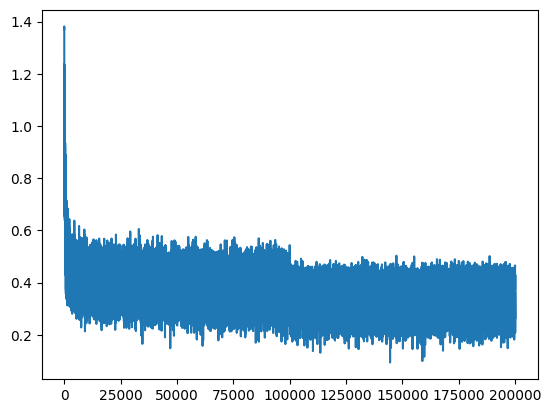

In [27]:
plt.plot(stepi, lossi)

In [28]:
# execute 1 forward pass on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_sz * emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytr)
print(loss)

tensor(2.1886, grad_fn=<NllLossBackward0>)


In [29]:
# execute 1 forward pass on test set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_sz * emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
print(loss)

tensor(2.2054, grad_fn=<NllLossBackward0>)


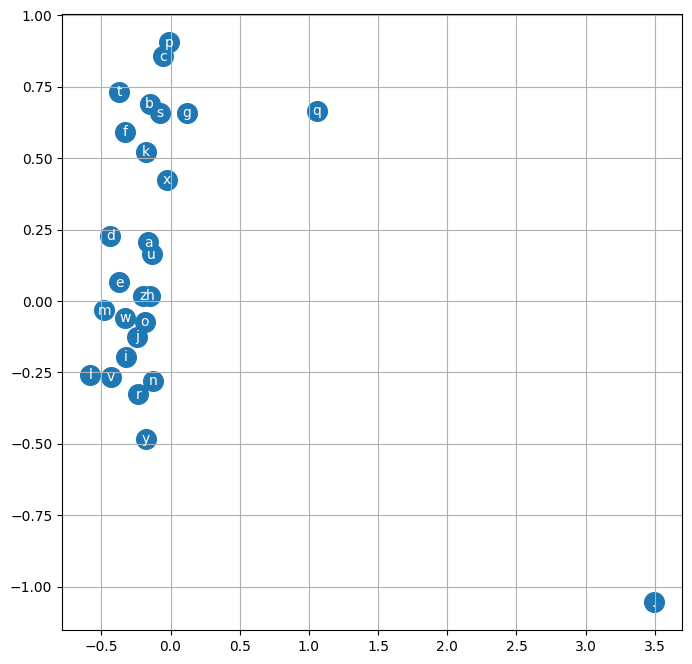

In [30]:
# this plot makes sense for 2-dimensional embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)  # x/y coordinates for 2-dimensional embeddings
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_sz
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)  # exponentiate & sum to 1
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

moraah.
yazziee.
medhah.
lorensa.
jendrlee.
azered.
eliileyghap.
leiel.
sanana.
selly.
malara.
noshig.
rilhiga.
stile.
renelle.
nocula.
ubelynd.
ryyshuf.
ehsyl.
ashiston.
